[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



🔹 Topic 1:  people, like, dont, one, would, im, get, think, time, u

🔹 Topic 2:  antiracism, musk, x, elon, uk, platform, medium, social, role, riot

🔹 Topic 3:  oligarch, fascist, enoughisenough, canada, usa, revolution, eattherich, cdnpoli, u, murica

🔹 Topic 4:  riot, uk, farright, tommyrobinson, racist, year, police, violence, last, southport

🔹 Topic 5:  antiracism, enoughisenough, trump, report, extremism, racism, thanks, time, school, black


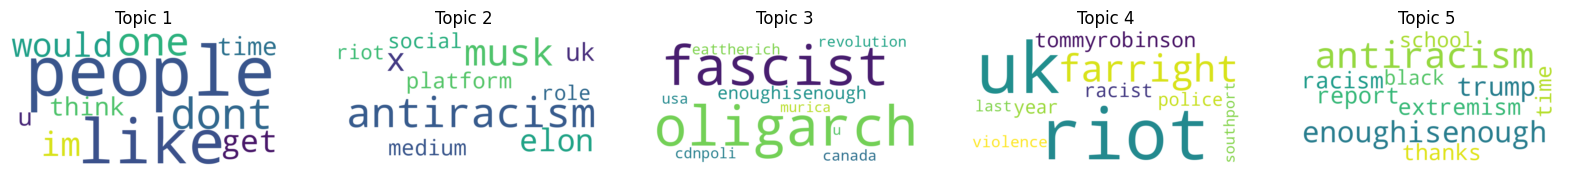

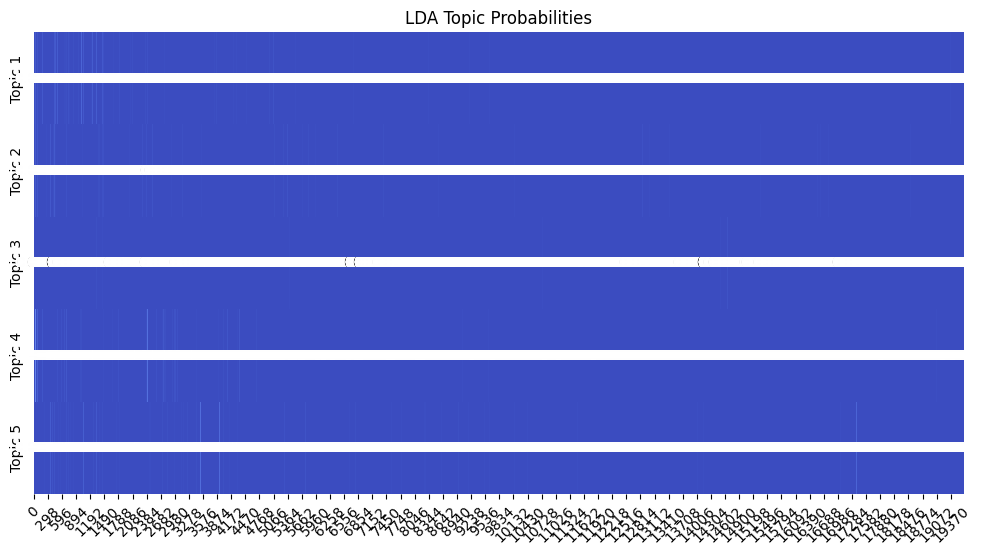

In [5]:
# Install required libraries if not already installed
!pip install pandas numpy nltk gensim wordcloud matplotlib scikit-learn

# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import re
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Dessertation/BlueSky - Riots.csv", encoding="latin1")

# Ensure text column exists and handle missing values
# If 'processed_text' column doesn't exist, create it and fill NaN with empty strings
if 'processed_text' not in df.columns:
    df['processed_text'] = df['text'].fillna("")  # Use raw text if preprocessing was lost
# If 'processed_text' column exists, fill NaN with empty strings
else:
    df['processed_text'] = df['processed_text'].fillna("")

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return tokens

# Apply preprocessing to dataset
df['cleaned_tokens'] = df['processed_text'].apply(preprocess_text)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['cleaned_tokens'])
corpus = [dictionary.doc2bow(text) for text in df['cleaned_tokens']]

# Train LDA model
num_topics = 5  # Number of topics to detect
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Display detected topics
for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print(f"\n🔹 Topic {idx+1}: ", ", ".join([word[0] for word in topic]))

# Visualizing the topics using a word cloud
fig, axes = plt.subplots(1, num_topics, figsize=(20, 5))
for i, ax in enumerate(axes.flatten()):
    topic_words = dict(lda_model.show_topic(i, 10))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Topic {i+1}")
    ax.axis("off")

plt.show()

# Visualizing the topics with bar charts
topic_keywords = []
for topic_id in range(num_topics):
    words = lda_model.show_topic(topic_id, 10)
    topic_keywords.append([word[0] for word in words])

df_topics = pd.DataFrame(topic_keywords, index=[f"Topic {i+1}" for i in range(num_topics)], columns=[f"Word {i+1}" for i in range(10)])

# Plot topic keyword distribution
plt.figure(figsize=(12, 6))
# Create a new DataFrame with the topic probabilities for the heatmap
topic_probs = lda_model.get_topics()  # Get topic probabilities as a NumPy array
df_topic_probs = pd.DataFrame(topic_probs, index=[f"Topic {i+1}" for i in range(num_topics)])

# Plot the heatmap using the topic probabilities
sns.heatmap(df_topic_probs, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
plt.title("LDA Topic Probabilities")
plt.xticks(rotation=45)
plt.show()